In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import nltk
import config as cfg

## NLP Pipeline Classes  
Adapted from [Zach Miller's pipeline project](https://github.com/ZWMiller/nlp_pipe_manager)

### Preprocessor Class

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

class nlp_preprocessor:
   
    def __init__(self, vectorizer=None, tokenizer=None, cleaning_function=None, 
                 stemmer=None, model=None):
        """
        A class for pipelining our data in NLP problems. The user provides a series of 
        tools, and this class manages all of the training, transforming, and modification
        of the text data.
        ---
        Inputs:
        vectorizer: the model to use for vectorization of text data
        tokenizer: The tokenizer to use, if none defaults to split on spaces
        cleaning_function: how to clean the data, if None, defaults to the in built class
        """
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.default_clean
        if not vectorizer:
            vectorizer = CountVectorizer(tokenizer=dummy,preprocessor=dummy)
        else:
            vectorizer.tokenizer = dummy
            vectorizer.preprocessor = dummy
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def dummy(doc):
        return doc
        
    def splitter(self, text):
        """
        Default tokenizer that splits on spaces naively
        """
        return text.split(' ')
        
    def preprocess(self, docs, tokenizer,stemmer,cleaning_function):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_docs = []
        for doc in docs:
            cleaned_tokens = []
            for token in tokenizer(doc):
                token_word_list = []
                for word in token:
                    clean_word = cleaning_function(word)
                    if stemmer:
                        clean_word = stemmer.stem(clean_word)
                    token_word_list.append(clean_word)
                cleaned_tokens.append(tuple(token_word_list))
            cleaned_docs.append(cleaned_tokens)
        return cleaned_docs
    
    def default_clean(self, word):
        return word.lower()
    
    def clean_text_old(self, text, tokenizer, stemmer):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if stemmer:
                    low_word = stemmer.stem(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text
    
    def fit(self, docs):
        """
        Cleans the data and then fits the vectorizer with
        the user provided text
        """
        clean_text = self.preprocess(docs, self.tokenizer, self.stemmer,self.cleaning_function)
        self.vectorizer.fit(clean_text)
        self._is_fit = True
        
    def transform(self, docs):
        """
        Cleans any provided data and then transforms the data into
        a vectorized format based on the fit function. Returns the
        vectorized form of the data.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        clean_text = self.preprocess(docs, self.tokenizer, self.stemmer,self.cleaning_function)
        return self.vectorizer.transform(clean_text)

### Supervised Learning Class

In [178]:
class supervised_nlp:
    
    def __init__(self, model, preprocessing_pipeline=None):
        """
        A pipeline for doing supervised nlp. Expects a model and creates
        a preprocessing pipeline if one isn't provided.
        """
        self.model = model
        self._is_fit = False
        if not preprocessing_pipeline:
            self.preprocessor = nlp_preprocessor()
        else:
            self.preprocessor = preprocessing_pipeline
        
    def fit(self, X, y):
        """
        Trains the vectorizer and model together using the 
        users input training data.
        """
        self.preprocessor.fit(X)
        train_data = self.preprocessor.transform(X)
        self.model.fit(train_data, y)
        self._is_fit = True
    
    def predict(self, X):
        """
        Makes a prediction on the data provided by the users using the 
        preprocessing pipeline and provided model.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        test_data = self.preprocessor.transform(X)
        preds = self.model.predict(test_data)
        return preds
    
    def score(self, X, y):
        """
        Returns the accuracy for the model after using the trained
        preprocessing pipeline to prepare the data.
        """
        test_data = self.preprocessor.transform(X)
        return self.model.score(test_data, y)

### Unsupervised Learning Class

In [179]:
class topic_modeling_nlp:
    
    def __init__(self, model, preprocessing_pipeline=None):
        """
        A pipeline for doing supervised nlp. Expects a model and creates
        a preprocessing pipeline if one isn't provided.
        """
        self.model = model
        self._is_fit = False
        if not preprocessing_pipeline:
            self.preprocessor = nlp_preprocessor()
        else:
            self.preprocessor = preprocessing_pipeline
        
    def fit(self, X):
        """
        Trains the vectorizer and model together using the 
        users input training data.
        """
        self.preprocessor.fit(X)
        train_data = self.preprocessor.transform(X)
        self.model.fit(train_data)
        self._is_fit = True
    
    def transform(self, X):
        """
        Makes a prediction on the data provided by the users using the 
        preprocessing pipeline and provided model.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        test_data = self.preprocessor.transform(X)
        preds = self.model.transform(test_data)
        return preds
    
    def print_topics(self, num_words=10):
        """
        A function to print out the top words for each topic
        """
        feat_names = self.preprocessor.vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(self.model.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([feat_names[i]
                                 for i in topic.argsort()[:-num_words - 1:-1]])
            print(message)

## Preprocessing Parts (In Order Applied)

### Tokenizer

In [180]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

In [181]:
client = MongoClient(**cfg.config)

db = client.youtube

_ , all_captions = get_rec_vids(db.recommendations,filter_dict={})

In [182]:
sentences = [sent_tokenize(text) for text in all_captions]
phrases = Phrases(sentences, min_count=1, threshold=1)  # train model
bigram = Phraser(phrases)  # construct faster model (this is only an wrapper)

def gensim_tokenizer(text):
    return bigram[word_tokenize(text)]

In [227]:
def add_grams(tokenizer,num_grams):
    def token_engram(text):
        token_list = []
        if 1 in num_grams:
            token_list.append(tokenizer(text))
        for ngram in num_grams:
            if ngram == 1:
                continue
            token_list.append(ngrams(tokenizer(text),ngram))
        return [item for sublist in token_list for item in sublist]
    return token_engram

tokenizer_list = [
    add_grams(word_tokenize,[1]),
    add_grams(word_tokenize,[1,2]),
    TweetTokenizer(preserve_case=False).tokenize,
    gensim_tokenizer,
    TreebankWordTokenizer().tokenize
]


tokenizer_labels = [
    'word_tokenizer',
    'bigram',
    'TweetTokenizer',
    'GenSimTokenizer',
    'TreeBankTokenizer'
]

### Cleaning Function

In [228]:
def lower_clean(word):
    return word.lower()

cleaner_list = [lower_clean]

cleaner_label = ['lower']

### Stemmer / Lemmatizer

In [229]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

class WordNetLemmatizerStemAttribute(WordNetLemmatizer):
    def stem(self, word):
        return self.lemmatize(word)

stemmer_list = [
    PorterStemmer(),
    SnowballStemmer('english'),
    LancasterStemmer(),
    WordNetLemmatizerStemAttribute(),
    None
]


stemmer_labels = [
    'PorterStemmer',
    'SnowballStemmer',
    'LancasterStemmer',
    'WordNetLemmatizer',
    'None'
]

### Vectorizer

In [230]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_list = [
    CountVectorizer(stop_words='english',min_df=0.0,max_df=1.0),
    TfidfVectorizer(stop_words='english',min_df=0.0,max_df=1.0),
    CountVectorizer(stop_words='english',min_df=0.1,max_df=0.9),
    TfidfVectorizer(stop_words='english',min_df=0.1,max_df=0.9),
    CountVectorizer(stop_words='english',min_df=0.2,max_df=0.8),
    TfidfVectorizer(stop_words='english',min_df=0.2,max_df=0.8),
    CountVectorizer(stop_words='english',min_df=0.3,max_df=1.0),
    TfidfVectorizer(stop_words='english',min_df=0.3,max_df=1.0),
]

vectorizer_label = [
    'CV',
    'TF-IDF',    
    'CV',
    'TF-IDF',
    'CV',
    'TF-IDF',
    'CV',
    'TF-IDF'
]

min_df_label = [
    0.0,
    0.0,
    0.1,
    0.1,
    0.2,
    0.2,
    0.3,
    0.3
]

max_df_label = [
    1.0,
    1.0,
    0.9,
    0.9,
    0.8,
    0.8,
    1.0,
    1.0
]

## Test Data

In [187]:
client = MongoClient(**cfg.config)

db = client.youtube

In [188]:
def get_caption_block(videoID):
    try:
        return db.captions.find_one({'videoID' : videoID},{'_id' : 0, 'caption_block' : 1})['caption_block']
    except:
        return None

def get_rec_vids(collection,filter_dict={}):
    pipeline = [
        {'$unwind': '$videos'}, 
        {'$match': filter_dict},
        {'$project': {'_id': 0, 'query' : 1, 'order' : '$videos.order', 'videoID' : '$videos.videoID'}}
    ]
    
    vid_df = pd.DataFrame(list(collection.aggregate(pipeline)))
    vid_df['caption'] = vid_df['videoID'].apply(get_caption_block)
    caption_series = vid_df['caption']
    caption_series.index = list(vid_df['videoID'])
    caption_series = caption_series.dropna().drop_duplicates()

    return vid_df, caption_series

In [189]:
pd.read_csv('request_log.csv')

,requestID,query,max_results,request_status,datetime,max_rec
0,da23078c-bf88-4024-91e9-d6cc6df4353a,global warming,50,202,"Sat, 17 Aug 2019 18:25:00 GMT",NaN
1,f211c3a5-9ffc-4cd1-a700-6448aae3f589,gun rights,50,202,"Sat, 17 Aug 2019 18:25:03 GMT",NaN
2,fd4189b0-8c3b-4821-a5cc-59fee424c73e,donald trump rally,50,202,"Sat, 17 Aug 2019 18:25:49 GMT",NaN
3,f3af736f-91ea-46a6-88ff-7e44f206e5d2,abortion pro life,50,202,"Sat, 17 Aug 2019 18:26:16 GMT",NaN
4,459bdd9e-41b0-44d9-a830-68e39e343a6d,global warming,50,202,"Tue, 20 Aug 2019 20:05:45 GMT",1.0
5,cea3d2e2-aa93-40d8-9c23-008e712a18e7,mass shootings,50,202,"Tue, 20 Aug 2019 20:53:27 GMT",1.0
6,759c13a9-fe38-423b-ab49-f72da297e8f3,abortion,50,202,"Tue, 20 Aug 2019 20:53:55 GMT",1.0
7,334b3ff3-e95e-4588-a531-b39664f96384,china hong kong,50,202,"Tue, 20 Aug 2019 20:56:54 GMT",1.0


In [190]:
filter_query = {"$or":[ {"videos.order":1}, {"videos.order":2}]}

In [191]:
test_meta , test_captions = get_rec_vids(db.recommendations,filter_dict=filter_query)

## Building Preprocessors

In [204]:
pd.DataFrame(test_captions.index)

,0
0,vGPU5SWV1DE
1,6afu04-KO90
2,CNkVGiSgOM4
3,McRYTC56DC4
4,ldLBoErAhz4
5,SY6XSsF4CCo
6,_YNfA7mDri4
7,oBIQbja-BPY
8,Qi7Ak_wsqaQ
9,TkRdM8db_qY


In [215]:
query_lookup = test_meta[['videoID','query']].drop_duplicates(subset=['videoID'])

y = pd.merge(pd.DataFrame(test_captions.index),query_lookup,
         how='left',left_on=[0],right_on=['videoID'])['query']

y

0          global warming
1          global warming
2          global warming
3          global warming
4          global warming
5          global warming
6          global warming
7          global warming
8          global warming
9          global warming
10         global warming
11         global warming
12         global warming
13         global warming
14         global warming
15         global warming
16         global warming
17         global warming
18         global warming
19         global warming
20             gun rights
21             gun rights
22         global warming
23         global warming
24             gun rights
25             gun rights
26             gun rights
27     donald trump rally
28      abortion pro life
29         global warming
              ...        
187     abortion pro life
188            gun rights
189            gun rights
190            gun rights
191        global warming
192     abortion pro life
193     abortion pro life
194     abor

In [216]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_captions, y, test_size=0.2, random_state=42)

In [217]:
preprocessor_list = []
counter = 0

for tokenizer in tokenizer_list:
    for cleaner in cleaner_list:
        for stemmer in stemmer_list:
            for vectorizer in vectorizer_list:
                counter += 1 
                print(counter)
                
                nlp_dict = {}

                
                nlp = nlp_preprocessor(vectorizer=vectorizer,tokenizer=tokenizer,
                                       cleaning_function=cleaner,stemmer=stemmer)
                
                nlp_dict['nlp'] = nlp
                

                nlp.fit(test_captions)
                
                nlp_dict['untrained'] = nlp.transform(test_captions)
                
                nlp.fit(X_train)
                
                nlp_dict['xtrain'] = nlp.transform(X_train)
                nlp_dict['xtest'] = nlp.transform(X_test)
                preprocessor_list.append(nlp_dict)
                

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [175]:
doc_term_list[0]

<217x19907 sparse matrix of type '<class 'numpy.int64'>'
	with 139290 stored elements in Compressed Sparse Row format>

In [246]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD




scores_list = []


for preprocess_dict in preprocessor_list:
    
    score_dict = {}
    
    #unsupervised testing
    data_vectorized = preprocess_dict['untrained']
    
    NUM_TOPICS = 8
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='online',verbose=True)
    data_lda = lda.fit_transform(data_vectorized)
    
    nmf = NMF(n_components=NUM_TOPICS)
    data_nmf = nmf.fit_transform(data_vectorized)
    
    lsa = TruncatedSVD(n_components=NUM_TOPICS)
    data_lsa = lsa.fit_transform(data_vectorized)
    
    NUM_CLUSTERS = NUM_TOPICS
    
    km = KMeans(n_clusters=NUM_CLUSTERS,random_state=10,n_init=1) 
    score_dict['km_LDA'] = metrics.adjusted_rand_score(y,km.fit_predict(data_lda)) 
    score_dict['km_NMF'] = metrics.adjusted_rand_score(y,km.fit_predict(data_nmf)) 
    score_dict['km_LSA'] = metrics.adjusted_rand_score(y,km.fit_predict(data_lsa)) 
    
    #supervised testing
    
    supervised_x_train = preprocess_dict['xtrain']
    supervised_x_test = preprocess_dict['xtest']
    supervised_y_train = y_train
    supervised_y_test = y_test
    
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='online',verbose=True)
    data_lda_xtrain = lda.fit_transform(supervised_x_train)
    data_lda_xtest = lda.transform(supervised_x_test)
    
    nmf = NMF(n_components=NUM_TOPICS)
    data_nmf_xtrain = nmf.fit_transform(supervised_x_train)
    data_nmf_xtest = nmf.transform(supervised_x_test)
    
    lsa = TruncatedSVD(n_components=NUM_TOPICS)
    data_lsa_xtrain = lsa.fit_transform(supervised_x_train)
    data_lsa_xtest = lsa.transform(supervised_x_test)

    nb = GaussianNB()
    nb.fit(data_lda_xtrain, supervised_y_train)
    score_dict['nb_LDA'] = nb.score(data_lda_xtest,supervised_y_test)
    nb.fit(data_nmf_xtrain, supervised_y_train)
    score_dict['nb_NMF'] = nb.score(data_nmf_xtest,supervised_y_test)
    nb.fit(data_lsa_xtrain, supervised_y_train)
    score_dict['nb_LSA'] = nb.score(data_lsa_xtest,supervised_y_test)
    
    scores_list.append(score_dict)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration

iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteratio

iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of

iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of

iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteratio

iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteratio

iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 o

iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteratio

iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration

iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of

iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteratio

iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteratio

iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of

iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteratio

iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteratio

iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of

iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteratio

iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteratio

iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of

iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteratio

iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteratio

iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of

iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteratio

iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteratio

iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of

iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteratio

iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteratio

iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteratio

iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of

iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteratio

iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteratio

iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of

iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteratio

iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteratio

iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of

iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of

iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteratio

iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteratio

iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of

iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of

iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteratio

iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteratio

iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of

iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteratio

iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteratio

iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of

iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteratio

iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteratio

iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of

iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteratio

iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteratio

iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of

iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteratio

iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteratio

iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of

iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteratio

iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteratio

iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of

iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of

iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteratio

iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteratio

iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of

iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteratio

iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteratio

iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of

iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of

iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteratio

iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteratio

iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of

iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteratio

iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteratio

iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of

iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteratio

iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteratio

iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of

iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of

iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteratio

iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteratio

iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of

iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteratio

iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteratio

iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of

iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteratio

iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteratio

iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of

iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteratio

iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteratio

iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of

iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteratio

iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteratio

iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of

iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteratio

iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteratio

iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteratio

iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of

iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteratio

iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteratio

iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteratio

iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteratio

iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteratio

iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of

iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteratio

iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteratio

iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteratio

iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of

iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteratio

iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteratio

iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of

iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteratio

iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteratio

iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of

iteration: 66 of max_iter: 100
iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteratio

iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteratio

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteratio

iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteratio

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteration: 99 of max_iter: 100
iteratio

iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteration: 65 of max_iter: 100
iteration: 66 of max_iter: 100
iteratio

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteratio

iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteratio

iteration: 100 of max_iter: 100
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of

iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteratio

iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100
iteration: 36 of max_iter: 100
iteration: 37 of max_iter: 100
iteration: 38 of max_iter: 100
iteration: 39 of max_iter: 100
iteration: 40 of max_iter: 100
iteration: 41 of max_iter: 100
iteration: 42 of max_iter: 100
iteration: 43 of max_iter: 100
iteration: 44 of max_iter: 100
iteration: 45 of max_iter: 100
iteration: 46 of max_iter: 100
iteration: 47 of max_iter: 100
iteration: 48 of max_iter: 100
iteration: 49 of max_iter: 100
iteration: 50 of max_iter: 100
iteration: 51 of max_iter: 100
iteration: 52 of max_iter: 100
iteration: 53 of max_iter: 100
iteration: 54 of max_iter: 100
iteration: 55 of max_iter: 100
iteration: 56 of max_iter: 100
iteration: 57 of max_iter: 100
iteration: 58 of max_iter: 100
iteration: 59 of max_iter: 100
iteration: 60 of max_iter: 100
iteration: 61 of max_iter: 100
iteration: 62 of max_iter: 100
iteration: 63 of max_iter: 100
iteration: 64 of max_iter: 100
iteratio

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

iteration: 67 of max_iter: 100
iteration: 68 of max_iter: 100
iteration: 69 of max_iter: 100
iteration: 70 of max_iter: 100
iteration: 71 of max_iter: 100
iteration: 72 of max_iter: 100
iteration: 73 of max_iter: 100
iteration: 74 of max_iter: 100
iteration: 75 of max_iter: 100
iteration: 76 of max_iter: 100
iteration: 77 of max_iter: 100
iteration: 78 of max_iter: 100
iteration: 79 of max_iter: 100
iteration: 80 of max_iter: 100
iteration: 81 of max_iter: 100
iteration: 82 of max_iter: 100
iteration: 83 of max_iter: 100
iteration: 84 of max_iter: 100
iteration: 85 of max_iter: 100
iteration: 86 of max_iter: 100
iteration: 87 of max_iter: 100
iteration: 88 of max_iter: 100
iteration: 89 of max_iter: 100
iteration: 90 of max_iter: 100
iteration: 91 of max_iter: 100
iteration: 92 of max_iter: 100
iteration: 93 of max_iter: 100
iteration: 94 of max_iter: 100
iteration: 95 of max_iter: 100
iteration: 96 of max_iter: 100
iteration: 97 of max_iter: 100
iteration: 98 of max_iter: 100
iteratio

In [247]:
preprocess_labels = []

for tokenizer in tokenizer_labels:
    for cleaner in cleaner_label:
        for stemmer in stemmer_labels:
            for index , vectorizer in enumerate(vectorizer_label):
                label_dict = {}
                label_dict['tokenizer'] = tokenizer
                label_dict['stemmer'] = stemmer
                label_dict['vectorizer'] = vectorizer
                label_dict['min_df'] = min_df_label[index]
                label_dict['max_df'] = max_df_label[index]
                preprocess_labels.append(label_dict)
                
                

In [281]:
results = pd.concat([pd.DataFrame(preprocess_labels),pd.DataFrame(scores_list)],axis=1)

In [282]:
results.describe()

,max_df,min_df,km_LDA,km_LSA,km_NMF,nb_LDA,nb_LSA,nb_NMF
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.925000,0.150000,0.120661,0.107931,0.132679,0.442727,0.628864,0.626591
std,0.083124,0.112084,0.131119,0.083530,0.090886,0.214390,0.168498,0.148177
min,0.800000,0.000000,-0.005078,0.024889,0.038353,0.090909,0.409091,0.409091
25%,0.875000,0.075000,0.009817,0.031449,0.046070,0.272727,0.477273,0.471591
50%,0.950000,0.150000,0.028079,0.066338,0.111764,0.340909,0.556818,0.602273
75%,1.000000,0.225000,0.239025,0.187688,0.201179,0.659091,0.840909,0.772727
max,1.000000,0.300000,0.489909,0.315428,0.290310,0.886364,0.909091,0.840909


In [350]:
results_km = pd.melt(results.drop(columns=['nb_LDA','nb_LSA','nb_NMF']),
                     id_vars=['max_df','min_df','stemmer','tokenizer','vectorizer'],
                     value_vars=['km_LDA','km_LSA','km_NMF'],value_name='rand_score',var_name='topic_type')

results_km = results_km.replace({
    'km_LDA' : 'LDA',
    'km_LSA' : 'LSA',
    'km_NMF' : 'NMF'
})

results_nb = pd.melt(results.drop(columns=['km_LDA','km_LSA','km_NMF']),
                     id_vars=['max_df','min_df','stemmer','tokenizer','vectorizer'],
                     value_vars=['nb_LDA','nb_LSA','nb_NMF'],value_name='accuracy',var_name='topic_type')

results_nb = results_nb.replace({
    'nb_LDA' : 'LDA',
    'nb_LSA' : 'LSA',
    'nb_NMF' : 'NMF'
})

results_comb = results_km.copy(deep=True)
results_comb['accuracy'] = results_nb['accuracy']

Text(0.5, 1.0, 'KMeans Adj. Rand Score')

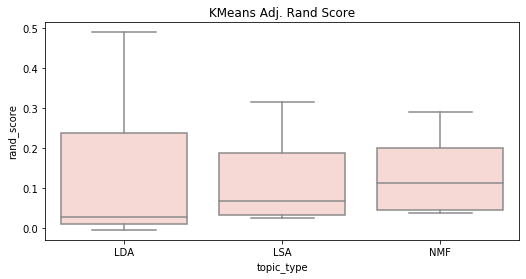

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8.5, 4))
ax = sns.boxplot(x="topic_type", y="rand_score", data=results_km, palette=['#FBD4D0'])
ax.set_title('KMeans Adj. Rand Score')


Text(0.5, 1.0, 'Naive Bayes Accuracy')

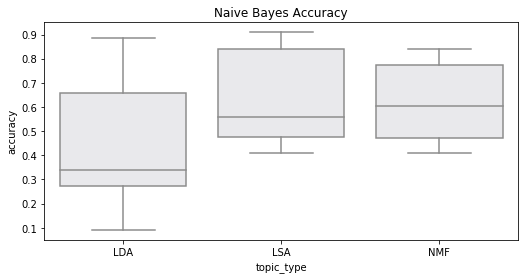

In [347]:
plt.figure(figsize=(8.5, 4))
ax = sns.boxplot(x="topic_type", y="accuracy", data=results_nb, palette=['#E8E9EC'])
ax.set_title('Naive Bayes Accuracy')

Text(0.5, 1.0, 'KMeans Adj. Rand Score')

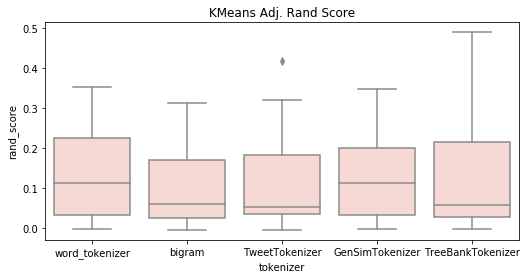

In [348]:
plt.figure(figsize=(8.5, 4))

ax = sns.boxplot(x="tokenizer", y="rand_score", data=results_km, palette=['#FBD4D0'])
ax.set_title('KMeans Adj. Rand Score')


Text(0.5, 1.0, 'Naive Bayes Accuracy')

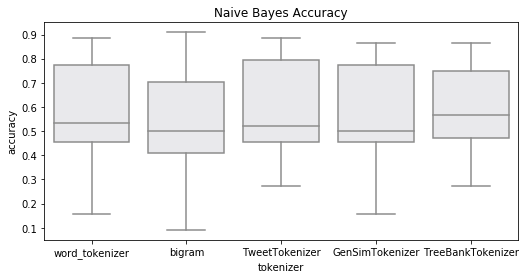

In [349]:
plt.figure(figsize=(8.5, 4))

ax = sns.boxplot(x="tokenizer", y="accuracy", data=results_nb, palette=['#E8E9EC'])
ax.set_title('Naive Bayes Accuracy')

In [353]:
results_comb.sort_values(['rand_score'],ascending=False).head(20).to_csv('preproccess_table.csv')

In [276]:
results_km.groupby(['variable'])[['rand_score','accuracy']].mean()

,rand_score,accuracy
variable,,
km_LDA,0.120661,0.442727
km_LSA,0.107931,0.628864
km_NMF,0.132679,0.626591


In [277]:
results_km.groupby(['tokenizer'])[['rand_score','accuracy']].mean()

,rand_score,accuracy
tokenizer,,
GenSimTokenizer,0.122261,0.567803
TreeBankTokenizer,0.133414,0.589205
TweetTokenizer,0.114047,0.569129
bigram,0.103856,0.542424
word_tokenizer,0.128538,0.561742
